### Tree mortality prediction based on growth patterns

data: [HF213](https://harvardforest1.fas.harvard.edu/exist/apps/datasets/showData.html?id=HF213)

Use classification algorithms to predict A(live) or D(ead) labels in __mortality13__ and __mortality14__ columns using these features:  
 - spp: USDA Plants database species code  
 - dbh09: diameter at Breast Height (1.4m) in year 2009 (unit: centimeter / missing value: NA)  
 - dbh11: diameter at Breast Height (1.4m) in year 2011 (unit: centimeter / missing value: NA)  
 - dbh12: diameter at Breast Height (1.4m) in year 2012 (unit: centimeter / missing value: NA)  
 - dbh13: diameter at Breast Height (1.4m) in year 2013 (unit: centimeter / missing value: NA)  
   
   
   
   
##### Tree mortality prediction based on growth patterns using Machine Learning
Forests are critically important for biodiversity and provide important health and economic benefits. Forests' response to climate change is however not very well understood. This project addresses the importance of tree growth rate for understanding and predicting tree mortality rates. It is hypothesized that trees' growth patterns across multiple species may have subtle changes when trees are under stress and that growth changes over time can be used as an early predictor for tree mortality. For tree growth we use Diameter at Breast Height (dbh) measurements collected 4, 2, 1 and 0 (during the year of tree death) years previous to tree death. For modelling, we trained data driven machine learning models for mortality prediction using data classification. Our results show that simple growth measurements can be used to predict mortality with a reasonable performance (>.65 Area under ROC curve on test data ).  Further studies should use larger datasets to see if the models’ accuracy can be increased. Mortality prediction models can further be used to understand which species are most likely to exhibit change in growth patterns under stress, as well as understand how early the changes appear before death.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import sys, os, pathlib, shutil, platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
)
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler


In [3]:
MINIMUM_COUNT = 10
TRAIN_DATA = 0.6

In [4]:
# !/opt/conda/bin/conda install -c anaconda seaborn pandas scikit-learn -y 


In [5]:
%matplotlib inline

In [6]:
# !pwd
# !ls -la ./../data/hrvardf/HF213

In [7]:
dataFileName='hf213-01-hf-inventory.csv'
dataPathFull= pathlib.Path('./../data/hrvardf/HF213') / dataFileName
myData = pd.read_csv(str(dataPathFull)) 

In [8]:
myData.shape
myData.head(2)
myData.tail(2)

(772, 27)

,site,plot,sub,tag,num,spp,x,y,dbh09,field.notes09,...,dbh13,mortality13,dmg13,field.notes13,date13,dbh14,mortality14,dmg14,field.notes14,date14
0,H,1,A,1634.0,1,ACRU,0.9,2.0,13.85,NaN,...,14.3,A,NaN,NaN,2013-09-06,14.3,A,NaN,measure on bump @DBH,2014-07-31
1,H,1,A,1634.0,2,ACRU,0.9,2.0,7.50,NaN,...,7.8,A,NaN,NaN,2013-09-06,7.8,A,NaN,NaN,2014-07-31


,site,plot,sub,tag,num,spp,x,y,dbh09,field.notes09,...,dbh13,mortality13,dmg13,field.notes13,date13,dbh14,mortality14,dmg14,field.notes14,date14
770,H,8,D,549.0,1,ACRU,3.4,14.2,NaN,NaN,...,14.0,A,NaN,NaN,2013-09-04,14.0,A,NaN,NaN,2014-08-03
771,H,8,D,550.0,1,PIST,4.1,11.8,NaN,NaN,...,11.8,IBS,S,S @ 4m; surviving branch growing horizontal,2013-09-04,11.8,D,NaN,NaN,2014-08-03


In [9]:
myData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772 entries, 0 to 771
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   site           772 non-null    object 
 1   plot           772 non-null    int64  
 2   sub            772 non-null    object 
 3   tag            772 non-null    float64
 4   num            772 non-null    int64  
 5   spp            772 non-null    object 
 6   x              772 non-null    float64
 7   y              772 non-null    float64
 8   dbh09          208 non-null    float64
 9   field.notes09  29 non-null     object 
 10  date09         208 non-null    object 
 11  dbh11          601 non-null    float64
 12  field.notes11  80 non-null     object 
 13  date11         603 non-null    object 
 14  dbh12          763 non-null    float64
 15  field.notes12  132 non-null    object 
 16  date12         763 non-null    object 
 17  dbh13          673 non-null    float64
 18  mortality1

In [10]:
# basic descriptive statistics for numeric columns:
myData.describe()

,plot,tag,num,x,y,dbh09,dbh11,dbh12,dbh13,dbh14
count,772.000000,772.000000,772.000000,772.000000,772.000000,208.000000,601.000000,763.000000,673.000000,767.000000
mean,4.405440,1967.688083,1.185233,7.334067,8.084326,16.828365,19.077304,19.179125,19.373626,19.290091
std,2.337895,2000.706430,0.515029,4.831483,4.565433,11.950456,12.646278,12.245192,12.366258,12.359763
min,1.000000,349.000000,1.000000,-13.500000,0.000000,2.200000,0.400000,0.595000,0.600000,0.400000
25%,2.000000,599.750000,1.000000,3.700000,4.700000,8.687500,10.050000,10.400000,10.350000,10.400000
50%,4.000000,812.500000,1.000000,7.800000,8.000000,13.775000,15.600000,16.000000,16.300000,16.200000
75%,6.000000,1742.000000,1.000000,11.000000,11.500000,21.037500,24.700000,25.050000,25.600000,25.300000
max,8.000000,9367.000000,5.000000,15.000000,59.100000,65.500000,87.000000,85.300000,85.600000,85.900000


In [11]:
# myData.groupby('spp').size()
myCols = ['spp', 'mortality13', 'dmg13']
myData[myCols[0]].value_counts(dropna=False) 
myData[myCols[1]].value_counts(dropna=False)
myData[myCols[2]].value_counts(dropna=False)
myData.pivot_table(index = [myCols[0]]
                   , columns = myCols[1]
                   , values =  myCols[2]
                   , aggfunc=np.sum, fill_value=0)
          


ACRU     204
TSCA     195
QURU      98
PIST      77
BELE      59
BEAL2     34
FAGR      33
BEPA      18
PIRU      14
QUAL       8
ACSA3      8
POGR4      6
FRAM       4
CADE       3
PRSE2      3
QUVE       2
HAVI4      2
CATO6      2
NYSY       1
PIRE       1
Name: spp, dtype: int64

A      566
NaN     98
IBS     58
D       42
M        8
Name: mortality13, dtype: int64

NaN         558
L           110
CD           15
DB           12
S            10
H             8
B             8
BBD           7
L;CD          6
TL            3
TL;L          3
L;BBD         2
BBD;CD        2
H;L           2
B;BBD         2
BBD;H;CD      2
DB;S          1
CD;L;S        1
DB;L          1
CD;S          1
BBD;L         1
S;TL          1
L;D           1
B;H;BBD       1
TL;CD         1
L;TL          1
BBD;B         1
L;H;DB        1
S;DB          1
S;D           1
H;DB          1
L;DB;S        1
HWA           1
IBS           1
L;DB          1
B;TL          1
LD            1
L;S           1
Name: dmg13, dtype: int64

,mortality13,A,D,IBS,M
spp,,,,,
ACSA3,dmg13,0,0,L;CD,0
BEAL2,dmg13,0,0,LCD,0
BELE,dmg13,0,SDB,0,0
BEPA,dmg13,0,0,0,0
CADE,dmg13,0,0,CDCD,0
CATO6,dmg13,0,0,0,0
FAGR,dmg13,0,S,BBD;H;CDBBD;H;CDBBD;CDB;H;BBD,B;BBD
FRAM,dmg13,0,0,L,0
HAVI4,dmg13,LL,0,0,0


<AxesSubplot:xlabel='spp', ylabel='count'>

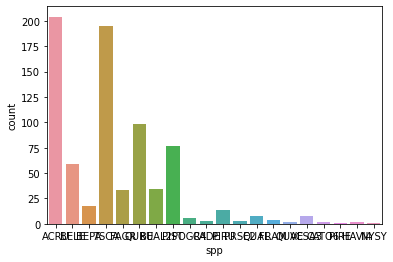

In [12]:
import seaborn as sns
sns.countplot(x= myData['spp'],label="spp Count")
plt.show()

In [13]:
myData['spp'].value_counts(dropna=False) 
removeSPP = myData['spp'].value_counts(dropna=False).loc[lambda x : x<MINIMUM_COUNT].index.tolist()
removeSPP

# filteredData = myData.replace(dict.fromkeys(removeSPP, 'TooFew'))
# filteredData['spp'].value_counts(dropna=False)

ACRU     204
TSCA     195
QURU      98
PIST      77
BELE      59
BEAL2     34
FAGR      33
BEPA      18
PIRU      14
QUAL       8
ACSA3      8
POGR4      6
FRAM       4
CADE       3
PRSE2      3
QUVE       2
HAVI4      2
CATO6      2
NYSY       1
PIRE       1
Name: spp, dtype: int64

['QUAL',
 'ACSA3',
 'POGR4',
 'FRAM',
 'CADE',
 'PRSE2',
 'QUVE',
 'HAVI4',
 'CATO6',
 'NYSY',
 'PIRE']

In [14]:
featureColumn_01=['spp', 'dbh09', 'dbh11', 'dbh12']
# featureColumn_01=[ 'dbh09', 'dbh11', 'dbh12']
labelColumn_01 = 'mortality13'
featureColumn_02=['spp', 'dbh09', 'dbh11', 'dbh12', 'dbh13']
# featureColumn_02=['dbh09', 'dbh11', 'dbh12', 'dbh13']
labelColumn_02 = 'mortality14' 

labelColumn = labelColumn_02
featureColumn = featureColumn_02

In [15]:
sorted(set(featureColumn+[labelColumn]))

['dbh09', 'dbh11', 'dbh12', 'dbh13', 'mortality14', 'spp']

In [16]:
filteredData = myData
filteredDataML = filteredData[sorted(set(featureColumn+[labelColumn]))]

filteredDataML.shape
filteredDataML.head()
filteredDataML[labelColumn].value_counts(dropna=False)

(772, 6)

,dbh09,dbh11,dbh12,dbh13,mortality14,spp
0,13.85,14.3,14.1,14.30,A,ACRU
1,7.50,7.9,7.8,7.80,A,ACRU
2,6.15,6.3,6.3,6.30,A,BELE
3,21.30,22.3,22.6,23.20,A,BELE
4,17.10,17.3,17.3,17.25,A,BEPA


A      599
IBS    114
D       57
M        1
NaN      1
Name: mortality14, dtype: int64

In [17]:
filteredDataML[labelColumn].value_counts(dropna=False)

filteredDataML = filteredDataML[filteredDataML[labelColumn].isin(['D', 'A'])]
filteredDataML.shape
filteredDataML.head()


filteredDataML[labelColumn].value_counts(dropna=False)

A      599
IBS    114
D       57
M        1
NaN      1
Name: mortality14, dtype: int64

(656, 6)

,dbh09,dbh11,dbh12,dbh13,mortality14,spp
0,13.85,14.3,14.1,14.30,A,ACRU
1,7.50,7.9,7.8,7.80,A,ACRU
2,6.15,6.3,6.3,6.30,A,BELE
3,21.30,22.3,22.6,23.20,A,BELE
4,17.10,17.3,17.3,17.25,A,BEPA


A    599
D     57
Name: mortality14, dtype: int64

In [18]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

catCols = filteredDataML.columns[filteredDataML.dtypes == 'O']
numCols = filteredDataML.columns[filteredDataML.dtypes == 'float64']
catCols
numCols


Index(['mortality14', 'spp'], dtype='object')

Index(['dbh09', 'dbh11', 'dbh12', 'dbh13'], dtype='object')

In [19]:
stratifySplit = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_DATA, random_state=1)

trainIdx, tstIdx = next(stratifySplit.split(filteredDataML, filteredDataML[labelColumn]))
# print("\n Train:", sorted(trainIdx))
len(trainIdx)
len(tstIdx)

filteredDataML.loc[filteredDataML.index.intersection(filteredDataML.index[trainIdx])].shape
filteredDataML[filteredDataML.index.isin(filteredDataML.index[trainIdx])].shape
aa=filteredDataML.loc[filteredDataML.index.intersection(filteredDataML.index[tstIdx])]
aa.shape
stratifySplit = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_DATA, test_size=1-TRAIN_DATA, random_state=1)
testIdx, validationIdx = next(stratifySplit.split(aa,  aa[labelColumn]))

len(testIdx)
len(validationIdx)
filteredDataML.shape

# testIdx=tstIdx[testIdx]
# validationIdx=tstIdx[validationIdx]

# print("\n Test:", sorted(testIdx))
# print("\nValidation:", sorted(validationIdx))

393

263

(393, 6)

(393, 6)

(263, 6)

157

106

(656, 6)

In [20]:
trainData=filteredDataML.loc[filteredDataML.index.intersection(filteredDataML.index[trainIdx]),:]
testData=aa.loc[aa.index.intersection(aa.index[testIdx]),:]
validationData = aa.loc[aa.index.intersection(aa.index[validationIdx]),:]

filteredDataML[labelColumn].value_counts(dropna=False)
trainData[labelColumn].value_counts(dropna=False) 
testData[labelColumn].value_counts(dropna=False) 
validationData[labelColumn].value_counts(dropna=False) 

A    599
D     57
Name: mortality14, dtype: int64

A    359
D     34
Name: mortality14, dtype: int64

A    143
D     14
Name: mortality14, dtype: int64

A    97
D     9
Name: mortality14, dtype: int64

In [21]:
ordinalEncoder = OrdinalEncoder()
ordinalEncoder.fit(filteredDataML[catCols])
ordinalEncoder.categories_

trainData[catCols] = ordinalEncoder.transform(trainData[catCols])
testData[catCols] = ordinalEncoder.transform(testData[catCols])
validationData[catCols] = ordinalEncoder.transform(validationData[catCols])

trainData.head()

OrdinalEncoder()

[array(['A', 'D'], dtype=object),
 array(['ACRU', 'ACSA3', 'BEAL2', 'BELE', 'BEPA', 'CADE', 'CATO6', 'FAGR',
        'FRAM', 'HAVI4', 'NYSY', 'PIRE', 'PIRU', 'PIST', 'POGR4', 'PRSE2',
        'QUAL', 'QURU', 'TSCA'], dtype=object)]

,dbh09,dbh11,dbh12,dbh13,mortality14,spp
0,13.85,14.3,14.1,14.30,0.0,0.0
1,7.50,7.9,7.8,7.80,0.0,0.0
2,6.15,6.3,6.3,6.30,0.0,3.0
3,21.30,22.3,22.6,23.20,0.0,3.0
4,17.10,17.3,17.3,17.25,0.0,4.0


In [22]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(trainData[featureColumn])


SimpleImputer(strategy='median')

In [23]:
trainData[featureColumn] = imputer.transform(trainData[featureColumn])
testData[featureColumn] = imputer.transform(testData[featureColumn])
validationData[featureColumn] = imputer.transform(validationData[featureColumn])

In [24]:
SVC_model = svm.SVC(kernel='rbf', random_state=0, gamma=.1, C=100, probability=True)
KNN_model = KNeighborsClassifier(n_neighbors=50)
RF_model = RandomForestClassifier(n_estimators=10, class_weight=dict({0:10000., 1:10.}))


SVC_model.fit(trainData[featureColumn], trainData[labelColumn])
KNN_model.fit(trainData[featureColumn], trainData[labelColumn])
RF_model.fit(trainData[featureColumn], trainData[labelColumn])

SVC(C=100, gamma=0.1, probability=True, random_state=0)

KNeighborsClassifier(n_neighbors=50)

RandomForestClassifier(class_weight={0: 10000.0, 1: 10.0}, n_estimators=10)

In [25]:
SVC_prediction = SVC_model.predict(testData[featureColumn])
KNN_prediction = KNN_model.predict(testData[featureColumn])
RF_prediction  = RF_model.predict(testData[featureColumn])

In [26]:
accuracy_score(SVC_prediction, testData[labelColumn])
accuracy_score(KNN_prediction, testData[labelColumn])
accuracy_score(RF_prediction, testData[labelColumn])

0.8980891719745223

0.910828025477707

0.8853503184713376

In [27]:
confusion_matrix(SVC_prediction, testData[labelColumn])
confusion_matrix(KNN_prediction, testData[labelColumn])
confusion_matrix(RF_prediction, testData[labelColumn])

array([[139,  12],
       [  4,   2]])

array([[143,  14],
       [  0,   0]])

array([[138,  13],
       [  5,   1]])

In [28]:
print(classification_report(SVC_prediction,  testData[labelColumn]))
print(classification_report(KNN_prediction,  testData[labelColumn]))
print(classification_report(RF_prediction,  testData[labelColumn]))

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95       151
         1.0       0.14      0.33      0.20         6

    accuracy                           0.90       157
   macro avg       0.56      0.63      0.57       157
weighted avg       0.94      0.90      0.92       157

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95       157
         1.0       0.00      0.00      0.00         0

    accuracy                           0.91       157
   macro avg       0.50      0.46      0.48       157
weighted avg       1.00      0.91      0.95       157

              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       151
         1.0       0.07      0.17      0.10         6

    accuracy                           0.89       157
   macro avg       0.52      0.54      0.52       157
weighted avg       0.93      0.89      0.91       157



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### SVM SVC ROC curve analysis

In [29]:
SVC_prediction_probs = SVC_model.predict_proba(testData[featureColumn])
fpr, tpr, thresholds = roc_curve(testData[labelColumn], SVC_prediction_probs[:, 1])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.685315


(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

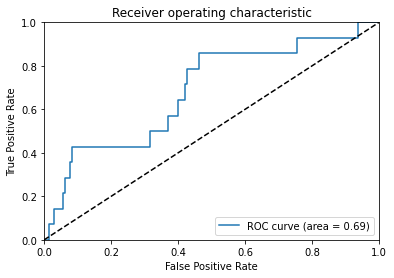

In [30]:
# Plot ROC curve
import pylab as pl
pl.clf()
pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], 'k--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.0])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic')
pl.legend(loc="lower right")
pl.show()